# Implementation details

This section describes how `%%testcell` has been implemented under the hood.

**NOTE**: we use `default_exp __init__` in order to enable this as soon as you import the module.

**WARNING**: cells magic are striped out during documentation generation; this is the reason why there is the same cell magic as comment too.

In [ ]:
#| default_exp __init__

In [ ]:
#| export
import ast
from IPython.core.magic import register_cell_magic, needs_local_scope
from IPython import get_ipython # needed for quarto

In [ ]:
#| export
from testcell.core import auto_display

In [ ]:
#| export
@register_cell_magic
@needs_local_scope
def testcell(line, cell, local_ns):
    if not ('skipdisplay' in line): cell = auto_display(cell)
    lines = cell.splitlines()

    # Wrap inside a function
    ret = ['def _test_cell_():']
    ret += ['\t'+x for x in lines]
    ret += ['try:\n\t_test_cell_()'] # execute it!
    ret += ['finally:\n\tdel _test_cell_'] # delete it
    wrapped_cell = '\n'.join(ret)

    if ('verbose' in line) or ('dryrun' in line): print('\n### BEGIN\n'+wrapped_cell+'\n### END')

    _globals = {} if ('noglobals' in line) else local_ns
    if not 'dryrun' in line: exec(wrapped_cell,_globals)

    if 'return_wrapped_cell' in line: return line, wrapped_cell
    else: pass

**IMPORTANT:** explicitly injectiong `globals` in exec is very important because the default behaviour may be different across multiple versions of IPython/Jupyter.

Let's define `%%testcelln`: a shortcut to `%%testcell noglobals`

In [ ]:
#| export
@register_cell_magic
@needs_local_scope
def testcelln(line, cell, local_ns):
    return testcell(line=line+ ' noglobals', cell=cell, local_ns=local_ns)

In [ ]:
aaa = "I'm in global scope"

In [ ]:
%%testcell
# %%testcell
print('"aaa" variable is in scope:','aaa' in globals().keys())

"aaa" variable is in scope: True


In [ ]:
%%testcelln
# %%testcelln
print('"aaa" variable is in scope:','aaa' in globals().keys())

"aaa" variable is in scope: False


In [ ]:
del aaa

### Standard use cases

Common use case when you want to seamlessly display the output of a computation

In [ ]:
%%testcell
# %%testcell
a=1
a=a+3
a

4

Despite this seems to be a *normal cell* variable `a` is not part of the global scope.

In [ ]:
assert 'a' not in locals()

If the last statement is a `display` or a `print` it works in any case

In [ ]:
%%testcell
# %%testcell
a=1
a=a+3
display(a)

4

All major use cases should be covered:

In [ ]:
%%testcell
# %%testcell

# simple inline
a=1; a

1

In [ ]:
%%testcell
# %%testcell

# complex inline
a=1; {'value': a,
      'note': 'complex multi line statement'}

{'value': 1, 'note': 'complex multi line statement'}

In [ ]:
assert 'a' not in locals()

### Available options

This magic supports the following options:

+ `noglobals` : this runs the cell in a completely isolated environment
+ `verbose` : it prints out the code before executing it
+ `dryrun` : just print the code without executing it
+ `skipdisplay` : do not try to wrap last line in a `display` statement.

Here are the examples

In [ ]:
%%testcell noglobals
# %%testcell noglobals
globals().keys()

dict_keys(['__builtins__', '_test_cell_'])

In [ ]:
%%testcell verbose
# %%testcell verbose
b=1
b


### BEGIN
def _test_cell_():
	# %%testcell verbose
	b=1
	display( # %%testcell
	b
	) # %%testcell
try:
	_test_cell_()
finally:
	del _test_cell_
### END


1

In [ ]:
%%testcell dryrun
# %%testcell dryrun
b=1
b


### BEGIN
def _test_cell_():
	# %%testcell dryrun
	b=1
	display( # %%testcell
	b
	) # %%testcell
try:
	_test_cell_()
finally:
	del _test_cell_
### END


In [ ]:
%%testcell dryrun skipdisplay
# %%testcell dryrun skipdisplay
b=1
b


### BEGIN
def _test_cell_():
	# %%testcell dryrun skipdisplay
	b=1
	b
try:
	_test_cell_()
finally:
	del _test_cell_
### END


Finally it properly works with any kind od *displayable* output too:

In [ ]:
# test imports
from PIL import Image
import numpy
import matplotlib.pyplot as plt

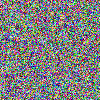

In [ ]:
%%testcell
# %%testcell
rng = numpy.random.default_rng(1234)
arr = rng.uniform(size=( 100,100,3)) * 255
img = Image.fromarray(arr.astype('uint8')).convert('RGB')
assert 'img' in locals()
img

In [ ]:
# Out of the test cell `img` has been removed
assert 'img' not in locals()

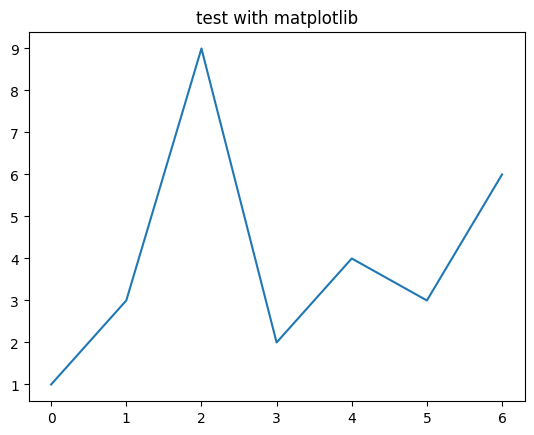

In [ ]:
%%testcell
# %%testcell
plt.plot([1,3,9,2,4,3,6])
plt.title('test with matplotlib');

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()